# TnpB - 1000 target nuclease analysis notebook - NM
#### Adapt cell line filter to run for HEK293T or N2A!

In [36]:
#celllinefilter = 'HEK293T'
celllinefilter = 'N2A'

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde
import scipy.stats as stats
from Bio.Seq import Seq
from Bio.SeqUtils import MeltingTemp as mt
import statsmodels.api as sm
from statsmodels.formula.api import ols
from Bio.SeqUtils import GC
import numpy as np
from collections import Counter, OrderedDict
from os import listdir
import logomaker
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import ShuffleSplit
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import shap
from itertools import product

In [38]:
lsize=14
titlesize=16
axesthickness = 1.5
flierprops = dict(marker='o',markersize=1.5)
boxplot_kwargs = {'widths':0.65, 'vert':True, 'patch_artist':True, 'boxprops':dict(facecolor='#FEFBF3'), 'whis':[5, 95]}
bar_kwargs = {'color':'#C5DEFF', 'edgecolor':'#000000', 'capsize':4, 'linewidth':1.5}
plt.rcParams['axes.linewidth'] = axesthickness
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'

### Import list of all experiments

In [39]:
#path='C:\\Users\\nimath\\switchdrive\\Institution\\PhD\\01_Experiments\\05_Various\\07_Kim_Marquart\\TnpB\\analysis\\AnalysisFiles\\'
path='./AnalysisFiles/'

def list_files1(directory):
    return [f for f in listdir(directory) if 'KM' in f]

sampleinfodf = pd.read_excel('Sample_Info.xlsx')
sampleinfodf = sampleinfodf.set_index('short_name')

sampledf = pd.DataFrame(columns=['filename','Library','Cell_line','Editor','Replicate'])
filelist = list_files1(path)
sampledf['filename'] = filelist
sampledf['shortname'] = sampledf['filename'].apply(lambda x: x.split('-')[-1][:-4])
sampledf = sampledf.set_index('shortname')
sampledf['Library'] = '1000member'
sampledf['Cell_line'] = sampleinfodf['cell_line']
sampledf['Editor'] = sampleinfodf['editor']
# rename none to "CTRL"
sampledf['Editor'] = sampledf['Editor'].apply(lambda x: 'CTRL' if x == 'none' else x)
sampledf['Replicate'] = sampleinfodf['replicate'].astype(str)
sampledf['Control'] = sampleinfodf['control_yes_no']
sampledf['repname'] = sampledf.apply(lambda x: x.Editor+"_"+x.Replicate,axis=1)

# ANALYZE ONLY specified cell line:
sampledf = sampledf[sampledf['Cell_line'] == celllinefilter]

In [40]:
sampledf

,filename,Library,Cell_line,Editor,Replicate,Control,repname
shortname,,,,,,,
KM_19,20230518_315991_49-KM_19.csv,1000member,N2A,opTnpB,1,no,opTnpB_1
KM_25,20230518_315991_55-KM_25.csv,1000member,N2A,opTnpB,2,no,opTnpB_2
KM_31,20230518_315991_61-KM_31.csv,1000member,N2A,opTnpB,3,no,opTnpB_3
KM_44,20230518_o303711_15-KM_44.csv,1000member,N2A,CTRL,1,yes,CTRL_1
KM_45,20230518_o303711_16-KM_45.csv,1000member,N2A,CTRL,2,yes,CTRL_2
KM_46,20230518_o303711_17-KM_46.csv,1000member,N2A,CTRL,3,yes,CTRL_3


In [41]:
templatedf = pd.read_csv('./20230518_TnpB_TWIST2_nuclease_REFERENCE.csv')

### Calculate control characteristics for each experimental setup

In [42]:
dataframe = pd.read_csv(path+'20230518_315991_31-KM_01.csv')
dataframe

,Unnamed: 0.1,Unnamed: 0,Identifier,lib_section,specific_primerpart,barcode,spacer,oligofinal,length,position_TAM,position_nick,spacer_part,Spacer_Length,target_rv,uneditedcount,indelcount,totalreads
0,0,1,1_RNA_MOTIFS_Dnmt1_musmus_1040_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,ACACCAA,TTCCGCCTCAATGATCTGCC,GACTTTAGTCGTGTGAGGTTCAATTCCGCCTCAATGATCTGCCGGC...,200,53,70,TTCCGCCTCA,20,AATGATCTGCCGAT,2532,452,2984
1,1,2,2_RNA_MOTIFS_Dnmt1_musmus_1042_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,AGATGAG,ACTTATGAAGATTCTCCCAT,GACTTTAGTCGTGTGAGGTTCAAACTTATGAAGATTCTCCCATGGC...,200,53,70,ACTTATGAAG,20,GATTCTCCCATGAT,1047,109,1156
2,2,3,3_RNA_MOTIFS_Dnmt1_musmus_1044_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,CAATAAG,GGTGGCGAGAAGGTGCTCAT,GACTTTAGTCGTGTGAGGTTCAAGGTGGCGAGAAGGTGCTCATGGC...,200,53,70,GGTGGCGAGA,20,AAGGTGCTCATGAT,1823,633,2456
3,3,4,4_RNA_MOTIFS_Dnmt1_musmus_1046_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,TGATTGA,GGAGCCCAGCAAAGAGTATG,GACTTTAGTCGTGTGAGGTTCAAGGAGCCCAGCAAAGAGTATGGGC...,200,53,70,GGAGCCCAGC,20,CAAAGAGTATGGAT,1334,309,1643
4,4,5,5_RNA_MOTIFS_Dnmt1_musmus_1048_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,AAGAGGA,CAGGTCTTCATATACAGCAT,GACTTTAGTCGTGTGAGGTTCAACAGGTCTTCATATACAGCATGGC...,200,53,70,CAGGTCTTCA,20,ATATACAGCATGAT,1847,603,2450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,1161,1162,1162_MISMATCH_SUB_ID_308_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,GCAACCG,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,GAACGTCTGT,20,TCCTTTGCCCTGAT,1691,541,2232
1162,1162,1163,1163_MISMATCH_SUB_ID_309_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,CCTTTGC,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,GAACGTCTGT,20,TCCTTAGGCCTGAT,677,855,1532
1163,1163,1164,1164_MISMATCH_SUB_ID_310_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,TTTGCGT,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,GAACGTCTGT,20,TCCTTACGGCTGAT,800,914,1714
1164,1164,1165,1165_MISMATCH_SUB_ID_311_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,CACATCT,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,GAACGTCTGT,20,TCCTTACCGGTGAT,968,776,1744


In [43]:
ctrllist = sampledf[sampledf['Editor'] == 'CTRL']
ctrldf = templatedf.copy()
for index, row in ctrllist.iterrows():
    controlrepdf = pd.read_csv(path+row.filename)
    ctrldf[row.repname+'_totalreads'] = controlrepdf['totalreads']
    controlrepdf['percentageindel'] = controlrepdf.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
    controlrepdf['percentageunedited'] = controlrepdf.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
    ctrldf[row.repname+'_percentageunedited'] = controlrepdf['percentageunedited']
    ctrldf[row.repname+'_percentageindel'] = controlrepdf['percentageindel']
    ctrldf[row.repname+'_uneditedcount'] = controlrepdf['uneditedcount']
    ctrldf[row.repname+'_indelcount'] = controlrepdf['indelcount']

for index, row in ctrllist.iterrows():    
    ctrldf = ctrldf[ctrldf[row.repname+'_totalreads'] > 100]
    ctrldf = ctrldf[ctrldf[row.repname+'_percentageindel'] < 15]

In [44]:
ctrldf

,Unnamed: 0,Identifier,lib_section,specific_primerpart,barcode,spacer,oligofinal,length,position_TAM,position_nick,...,CTRL_2_totalreads,CTRL_2_percentageunedited,CTRL_2_percentageindel,CTRL_2_uneditedcount,CTRL_2_indelcount,CTRL_3_totalreads,CTRL_3_percentageunedited,CTRL_3_percentageindel,CTRL_3_uneditedcount,CTRL_3_indelcount
0,1,1_RNA_MOTIFS_Dnmt1_musmus_1040_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,TTGGTGT,TTCCGCCTCAATGATCTGCC,GACTTTAGTCGTGTGAGGTTCAATTCCGCCTCAATGATCTGCCGGC...,200,53,70,...,22967,94.570471,5.429529,21720,1247,20098,94.765648,5.234352,19046,1052
1,2,2_RNA_MOTIFS_Dnmt1_musmus_1042_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,CTCATCT,ACTTATGAAGATTCTCCCAT,GACTTTAGTCGTGTGAGGTTCAAACTTATGAAGATTCTCCCATGGC...,200,53,70,...,5044,94.904837,5.095163,4787,257,4238,95.327985,4.672015,4040,198
2,3,3_RNA_MOTIFS_Dnmt1_musmus_1044_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,CTTATTG,GGTGGCGAGAAGGTGCTCAT,GACTTTAGTCGTGTGAGGTTCAAGGTGGCGAGAAGGTGCTCATGGC...,200,53,70,...,18861,93.552834,6.447166,17645,1216,16697,93.927053,6.072947,15683,1014
3,4,4_RNA_MOTIFS_Dnmt1_musmus_1046_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,TCAATCA,GGAGCCCAGCAAAGAGTATG,GACTTTAGTCGTGTGAGGTTCAAGGAGCCCAGCAAAGAGTATGGGC...,200,53,70,...,10624,94.390060,5.609940,10028,596,9270,94.714132,5.285868,8780,490
4,5,5_RNA_MOTIFS_Dnmt1_musmus_1048_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,TCCTCTT,CAGGTCTTCATATACAGCAT,GACTTTAGTCGTGTGAGGTTCAACAGGTCTTCATATACAGCATGGC...,200,53,70,...,13125,95.672381,4.327619,12557,568,11455,95.425578,4.574422,10931,524
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,1162,1162_MISMATCH_SUB_ID_308_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,CGGTTGC,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,...,18010,92.959467,7.040533,16742,1268,15721,92.824884,7.175116,14593,1128
1162,1163,1163_MISMATCH_SUB_ID_309_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,GCAAAGG,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,...,13679,92.799181,7.200819,12694,985,12082,93.006125,6.993875,11237,845
1163,1164,1164_MISMATCH_SUB_ID_310_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,ACGCAAA,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,...,17059,92.783868,7.216132,15828,1231,14670,93.353783,6.646217,13695,975
1164,1165,1165_MISMATCH_SUB_ID_311_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,AGATGTG,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,...,18218,93.297837,6.702163,16997,1221,16002,92.650919,7.349081,14826,1176


In [45]:
editorlist = sampledf['Editor'].unique()
editorlist = [x for x in editorlist if not 'CTRL' in x]
experimentdict = {}
for editor in editorlist:
    experimentdf = templatedf.copy()
    for index, row in sampledf[sampledf['Editor'] == editor].iterrows():
        dataframe = pd.read_csv(path+row.filename)
        dataframename = row.Editor+"_"+row.Replicate
        experimentdf[dataframename+'_totalreads'] = dataframe['totalreads']
        dataframe['percentageindel'] = dataframe.apply(lambda x: (x.indelcount/x.totalreads)*100 ,axis=1)
        dataframe['percentageunedited'] = dataframe.apply(lambda x: (x.uneditedcount/x.totalreads)*100 ,axis=1)
        experimentdf[dataframename+'_percentageunedited'] = dataframe['percentageunedited']
        experimentdf[dataframename+'_percentageindel'] = dataframe['percentageindel']
        experimentdf[dataframename+'_uneditedcount'] = dataframe['uneditedcount']
        experimentdf[dataframename+'_indelcount'] = dataframe['indelcount']
    replicates = list(sampledf[sampledf['Editor'] == editor].repname)
    controldf = sampledf[(sampledf['Editor'] == 'CTRL')]
    #controlname = controldf['Cell_line_Editor'] + '_' + controldf['Replicate']
    
    ctrluneditedlist = []
    ctrlindellist = []
    lib = "1000member"
    for index, row in ctrllist.iterrows():
        ctrluneditedlist.append(row.repname+'_percentageunedited')
        ctrlindellist.append(row.repname+'_percentageindel')
        
    experimentdf[lib+'_ctr'+'_percentageunedited'] = ctrldf[ctrluneditedlist].mean(axis=1)
    experimentdf[lib+'_ctr'+'_percentageindel'] = ctrldf[ctrlindellist].mean(axis=1)

    cutoff = 100
    initialtemplen = len(experimentdf)

    for replicate in replicates:
        experimentdf = experimentdf[experimentdf[replicate+'_totalreads']>cutoff]

    experimentdict[editor] = experimentdf

In [46]:
experimentdf

,Unnamed: 0,Identifier,lib_section,specific_primerpart,barcode,spacer,oligofinal,length,position_TAM,position_nick,...,opTnpB_2_percentageindel,opTnpB_2_uneditedcount,opTnpB_2_indelcount,opTnpB_3_totalreads,opTnpB_3_percentageunedited,opTnpB_3_percentageindel,opTnpB_3_uneditedcount,opTnpB_3_indelcount,1000member_ctr_percentageunedited,1000member_ctr_percentageindel
0,1,1_RNA_MOTIFS_Dnmt1_musmus_1040_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,TTGGTGT,TTCCGCCTCAATGATCTGCC,GACTTTAGTCGTGTGAGGTTCAATTCCGCCTCAATGATCTGCCGGC...,200,53,70,...,20.670597,2153,561,4353,80.955663,19.044337,3524,829,94.663382,5.336618
1,2,2_RNA_MOTIFS_Dnmt1_musmus_1042_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,CTCATCT,ACTTATGAAGATTCTCCCAT,GACTTTAGTCGTGTGAGGTTCAAACTTATGAAGATTCTCCCATGGC...,200,53,70,...,7.177033,970,75,1729,93.117409,6.882591,1610,119,95.064543,4.935457
2,3,3_RNA_MOTIFS_Dnmt1_musmus_1044_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,CTTATTG,GGTGGCGAGAAGGTGCTCAT,GACTTTAGTCGTGTGAGGTTCAAGGTGGCGAGAAGGTGCTCATGGC...,200,53,70,...,23.978618,1991,628,3913,77.025300,22.974700,3014,899,93.489414,6.510586
3,4,4_RNA_MOTIFS_Dnmt1_musmus_1046_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,TCAATCA,GGAGCCCAGCAAAGAGTATG,GACTTTAGTCGTGTGAGGTTCAAGGAGCCCAGCAAAGAGTATGGGC...,200,53,70,...,12.823834,1346,198,2372,87.015177,12.984823,2064,308,94.628481,5.371519
4,5,5_RNA_MOTIFS_Dnmt1_musmus_1048_HDV,RNA_Motifs,GACTGTCTACCACTTGTACTTCAGC,TCCTCTT,CAGGTCTTCATATACAGCAT,GACTTTAGTCGTGTGAGGTTCAACAGGTCTTCATATACAGCATGGC...,200,53,70,...,17.274569,1633,341,3000,80.533333,19.466667,2416,584,95.463057,4.536943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1161,1162,1162_MISMATCH_SUB_ID_308_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,CGGTTGC,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,...,7.578009,1866,153,3187,90.178852,9.821148,2874,313,92.695961,7.304039
1162,1163,1163_MISMATCH_SUB_ID_309_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,GCAAAGG,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,...,30.176644,1423,615,3180,70.031447,29.968553,2227,953,92.839178,7.160822
1163,1164,1164_MISMATCH_SUB_ID_310_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,ACGCAAA,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,...,22.531769,1585,461,3122,78.603459,21.396541,2454,668,93.176499,6.823501
1164,1165,1165_MISMATCH_SUB_ID_311_2MM_rev_oRNA_HEKs_18_...,MISMATCH_CONSEC,GACTGTCTACCACTTGTACTTCAGC,AGATGTG,GAACGTCTGTCCTTACCCCT,GACTTTAGTCGTGTGAGGTTCAAGAACGTCTGTCCTTACCCCTGGC...,200,53,70,...,20.625271,1828,475,3375,78.370370,21.629630,2645,730,92.972963,7.027037


### Calculate editing characteristics for all experimental setups
Also clip editing levels to be between 0-100.

In [47]:
sampledf_woctr = sampledf[sampledf['Editor'] != 'CTRL']

In [48]:
editordf = sampledf_woctr.copy()
editordf = editordf[editordf['Replicate'] == "1"]
editordf = editordf.set_index('Editor')

cols = ['Cell_line', 'Library']
editordf = editordf[cols]
editordf

,Cell_line,Library
Editor,,
opTnpB,N2A,1000member


In [49]:
for editor in experimentdict:
    print(editor)
    replicatelist = list(sampledf_woctr[sampledf_woctr['Editor'] == editor]['repname'])
    ctrname = lib+'_ctr'
    
    for replicate in replicatelist:
        print(replicate)
        repnr = replicate.split('_')[-1]
        experimentdict[editor][replicate+'_percentageindel_corrected_individual'] = experimentdict[editor].apply(lambda x: ((x[replicate+'_percentageindel']-x[ctrname+'_percentageindel'])/((100-x[ctrname+'_percentageindel'])/100)),axis=1)
        editordf.at[editor,repnr +'_meanindel'] = None
        editordf.at[editor,repnr +'_meanindel'] = experimentdict[editor][[replicate +'_percentageindel_corrected_individual']].mean()
        
    allreps = []
    for index,row in sampledf_woctr[sampledf_woctr['Editor'] == editor].iterrows():
        rep = row.Editor+'_'+row.Replicate
        allreps.append(rep)
        
    print(allreps)    
    experimentdict[editor][editor+'_averageindel'] = experimentdict[editor][[x +'_percentageindel_corrected_individual' for x in allreps]].mean(axis=1)
    
       
    # Clip editing rates to be between 0 and 100
    experimentdict[editor][editor+'_averageindel'] = experimentdict[editor][editor+'_averageindel'].clip(0,100)
    
    experimentdict[editor] = experimentdict[editor].dropna(subset=[editor+'_averageindel'])
    
    replist = ['1_meanindel','2_meanindel','3_meanindel']
    
    
    
    
    editordf.at[editor,'numberofvariants'] = len(experimentdict[editor])
    editordf.at[editor,'meanindel'] = experimentdict[editor][editor+'_averageindel'].mean()
    editordf.at[editor,'standarddeviation'] = experimentdict[editor][editor+'_averageindel'].std()
    experimentdict[editor].to_csv('./AnalysisFiles/summary/20230519_1000members'+celllinefilter+'_'+editor+'_analysis_dataframe.csv')

opTnpB
opTnpB_1
opTnpB_2
opTnpB_3
['opTnpB_1', 'opTnpB_2', 'opTnpB_3']


In [50]:
for index, row in editordf.iterrows():
    editordf.at[index,'replicate_meanindel'] = (row['1_meanindel'] + row['2_meanindel'] + row['3_meanindel']) / 3
    editordf.at[index,'replicate_std'] = np.std([row['1_meanindel'],row['2_meanindel'],row['3_meanindel']])

In [51]:
editordf = editordf.sort_index()
editordf['filename'] = editordf.apply(lambda x: '20230519_'+str(x.name)+'_analysis_dataframe.csv',axis=1)
editordf.to_csv('./AnalysisFiles/summary/20230519_'+celllinefilter+'_1000member_nuclease_summary_mean_std.csv')
editordf

,Cell_line,Library,1_meanindel,2_meanindel,3_meanindel,numberofvariants,meanindel,standarddeviation,replicate_meanindel,replicate_std,filename
Editor,,,,,,,,,,,
opTnpB,N2A,1000member,5.431687,5.808969,5.384118,1118.0,6.027179,6.283175,5.541592,0.190059,20230519_opTnpB_analysis_dataframe.csv


In [52]:
# Get all unique editor names from the index of editordf
unique_editors = editordf.index.unique()


combinations = [(1, 2), (1, 3), (2, 3)]

# List the measures to use
measure_types = ["percentageindel_corrected_individual", "percentageindel"]

# Loop through all unique editors
for editor in unique_editors:
    if editor in experimentdict:
        for measure_type in measure_types:
            cols = [f"{editor}_{i+1}_{measure_type}" for i in range(4)]
            for combination in combinations:
                print(f'Spearman correlation of replicates ({measure_type}) - {celllinefilter} - {editor}', combination)
                correlation = experimentdict[editor][cols[combination[0] - 1]].corr(
                    experimentdict[editor][cols[combination[1] - 1]], method='spearman')
                print(correlation)
                print()


Spearman correlation of replicates (percentageindel_corrected_individual) - N2A - opTnpB (1, 2)
0.9773385768649216

Spearman correlation of replicates (percentageindel_corrected_individual) - N2A - opTnpB (1, 3)
0.9826650931715283

Spearman correlation of replicates (percentageindel_corrected_individual) - N2A - opTnpB (2, 3)
0.9791390398306854

Spearman correlation of replicates (percentageindel) - N2A - opTnpB (1, 2)
0.9811758288549072

Spearman correlation of replicates (percentageindel) - N2A - opTnpB (1, 3)
0.9854627014217042

Spearman correlation of replicates (percentageindel) - N2A - opTnpB (2, 3)
0.9824263124701582



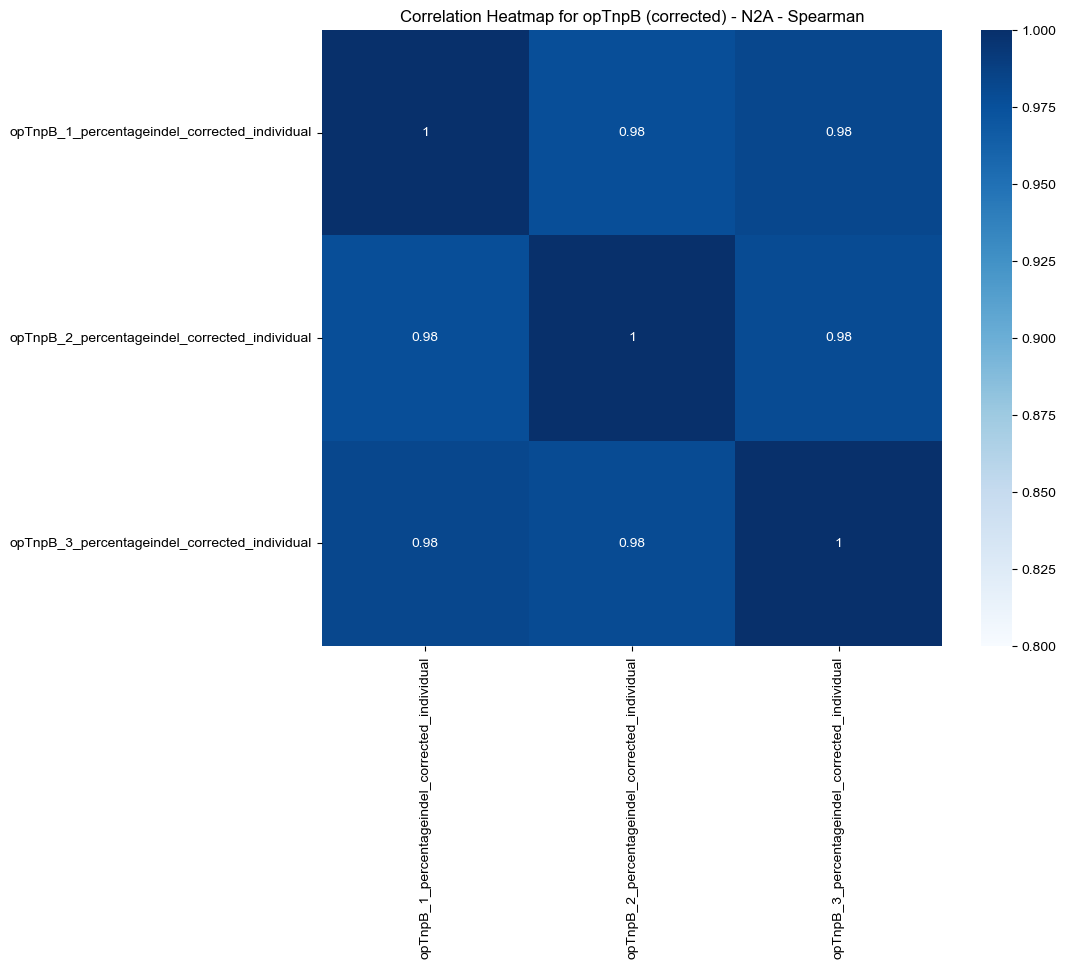

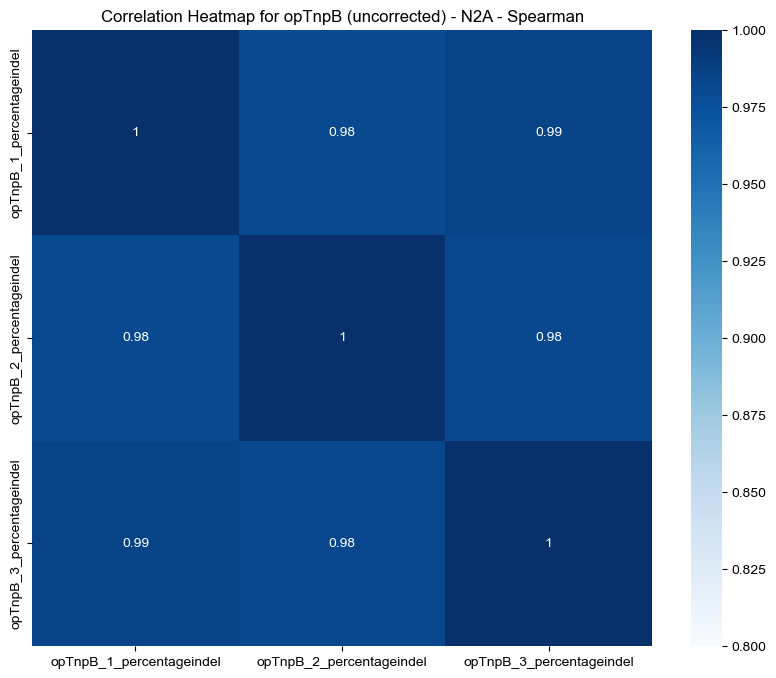

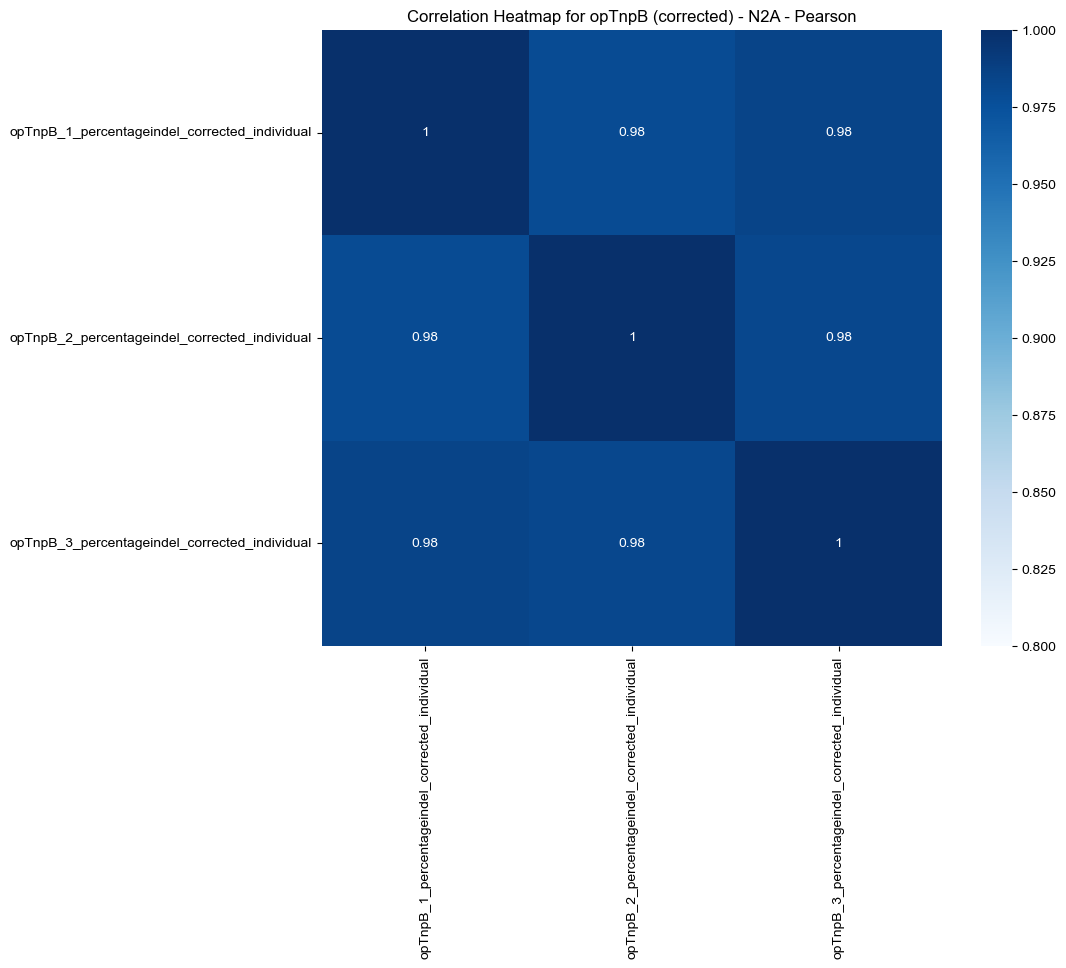

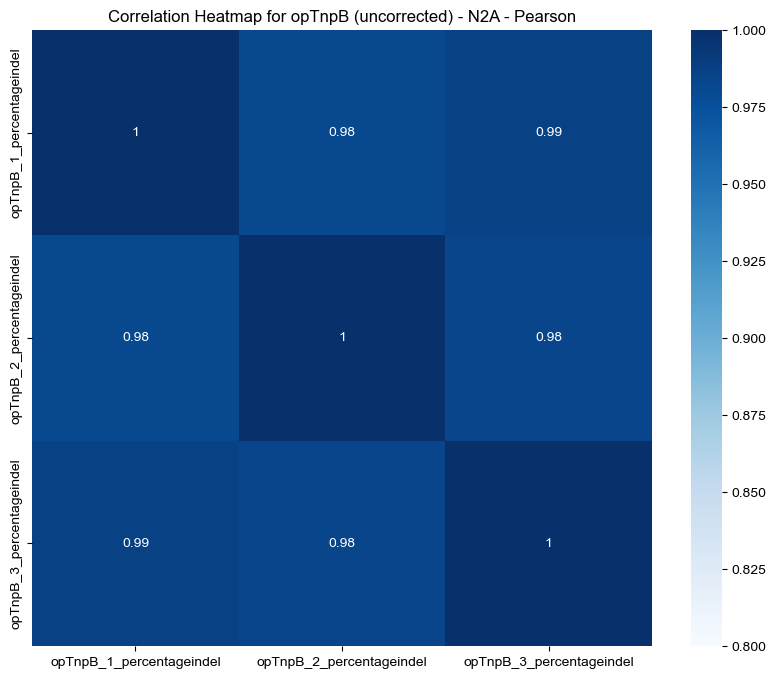

In [53]:
methods = ['spearman', 'pearson']
titles = ['Spearman', 'Pearson']

# Get all unique editor names from the index of editordf
unique_editors = editordf.index.unique()

# Loop through all unique editors
for editor in unique_editors:
    if editor in experimentdict:
        # Generate column names for this editor
        corrected_cols = [f"{editor}_{i+1}_percentageindel_corrected_individual" for i in range(3)]
        uncorrected_cols = [f"{editor}_{i+1}_percentageindel" for i in range(3)]
        
        for method, title in zip(methods, titles):
            # Heatmap for this editor (corrected)
            correlation_matrix = experimentdict[editor][corrected_cols].corr(method=method)
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=True, cmap='Blues', vmin=0.8, vmax=1)
            plt.title(f'Correlation Heatmap for {editor} (corrected) - '+celllinefilter+f' - {title}')
            plt.savefig(f'figures/'+celllinefilter+f'_{editor}_corrected_{title}.pdf')
            plt.show()
        
            # Heatmap for this editor (uncorrected)
            correlation_matrix = experimentdict[editor][uncorrected_cols].corr(method=method)
            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=True, cmap='Blues', vmin=0.8, vmax=1)
            plt.title(f'Correlation Heatmap for {editor} (uncorrected) - '+celllinefilter+f' - {title}')
            plt.savefig(f'figures/'+celllinefilter+f'_{editor}_uncorrected_{title}.pdf')
            plt.show()
